In [1]:
import random
import numpy  as np

# Load in the data

In [2]:
#Import libaries
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, ifft
from scipy.io import wavfile 
from scipy.signal import filtfilt, butter
from pylab import *
import os
import librosa

#Import self-written functions
from HD_model import HD_statistical_functions as sf
from HD_Model_NEW import HD_DataLoader as dl

In [3]:
# generate database
HD_dl = dl.HD(r'E:\5ARIP0_Interdisciplinary_team_project\data_analyse\5ARIP10\HD_Model_NEW\HD_data')
HD_database = HD_dl.generate_database()
# vair_dl = dl.VairableSensorsDataset(database = HD_database, mic_bool = 'True', vibr_bool = 'False', cur_bool = 'True', 
#                                    speed_bool='False', start_percentage=0.1, stop_percentage = 0.9, window_sec = 0.5, stride_sec=0.2)
# print(HD_database)

---------------------------------------------------------
Generating database for HD's


In [4]:
""" # load vibration data

anom_vibr = []
norm_vibr = []

keys_vibr = ['X_vibr', 'Y_vibr', 'Z_vibr']
for test in HD_database:
    if HD_database[test]['attributes']['HD_status'] == 1:  # it is faulty HD
        vibr = {key: HD_database[test]['Vibration'][key] for key in keys_vibr}
        anom_vibr.append([vibr[key] for key in keys_vibr])
    elif HD_database[test]['attributes']['HD_status'] == 0:  # it is working HD
        vibr = {key: HD_database[test]['Vibration'][key] for key in keys_vibr}
        norm_vibr.append([vibr[key] for key in keys_vibr])

anom_vibr = np.array(anom_vibr)
norm_vibr = np.array(norm_vibr)
vibr_data = np.concatenate((norm_vibr, anom_vibr), axis=0)

print(vibr_data.shape) """

##### load microphone data

anom_mic = []
norm_mic = []

keys_mic = ['Data']
for test in HD_database:
    if HD_database[test]['attributes']['HD_status'] == 1:  # it is faulty HD
        mic = {key: HD_database[test]['Microphone'][key] for key in keys_mic}
        anom_mic.append([mic[key] for key in keys_mic])
    elif HD_database[test]['attributes']['HD_status'] == 0:  # it is working HD
        mic = {key: HD_database[test]['Microphone'][key] for key in keys_mic}
        norm_mic.append([mic[key] for key in keys_mic])

anom_mic = np.array(anom_mic)
norm_mic = np.array(norm_mic)
mic_data = np.concatenate((norm_mic, anom_mic), axis=0)

# only keep the left stereo, since the difference of left and right stereos is very small:
# shape:[12*1*2646000*2]-> shape:[12*1*2646000]
mic_data = mic_data[:, :, :, 0]

# eliminate dimensions of only one element
# shape:[12*1*2646000]-> shape:[12*2646000]
mic_data = np.squeeze(mic_data)
print(mic_data.shape)



###### load current data

anom_current = []
norm_current = []

keys_current = ['i_motor_LP']
for test in HD_database:
    if HD_database[test]['attributes']['HD_status'] == 1:  # it is faulty HD
        current = {key: HD_database[test]['dSpace'][key] for key in keys_current}
        anom_current.append([current[key] for key in keys_current])
    elif HD_database[test]['attributes']['HD_status'] == 0:  # it is working HD
        current = {key: HD_database[test]['dSpace'][key] for key in keys_current}
        norm_current.append([current[key] for key in keys_current])

def find_min_len(current_data):
    """ 
    find the minimum length of the elements in one two-dimensional current data list
    """
    min_len = current_data[0][0].shape
    for i in range (len(current_data) - 1):
        if current_data[i][0].shape > current_data[i+1][0].shape:
            min_len = current_data[i+1][0].shape
    min_len = int(min_len[0])
    return min_len

# find min length of both anom and norm current data
anom_min_len = find_min_len(anom_current)
norm_min_len = find_min_len(norm_current)
current_min_len = min(anom_min_len, norm_min_len)
# print(current_min_len)

# resize all both the anom and norm current data into the min length and concatenate them
for i in range (len(anom_current)):
    anom_current[i][0] = np.resize(anom_current[i][0], current_min_len)
for i in range (len(norm_current)):
    norm_current[i][0] = np.resize(norm_current[i][0], current_min_len)
anom_current = np.array(anom_current)
norm_current = np.array(norm_current)
current_data = np.squeeze(np.concatenate((norm_current, anom_current), axis=0))

print(current_data.shape)


(12, 2646000)
(12, 30228)


# extract features

In [12]:
# extract features

mic_time_feats = sf.extract_time_features(data = mic_data, x = 44100)   # use fs as x
mic_fft_feats = sf.extract_fft_features(data=mic_data, x = 44100)   # use fs as x
# using x = (current_min_len/60) could produce the same n_time_windows as mic data
current_time_feats = sf.extract_time_features(data=current_data, x = int(current_min_len/60))  

print(current_time_feats.shape)
print(mic_time_feats.shape)
print(mic_fft_feats.shape)



# normalize features (due to the large difference between different features)
def normlize_feats(feature_map):
    # normalize feature map (use min-max normalizaton: (x-min)/(max-min))
    for i in range(feature_map.shape[1]):
        colomn_min = np.min(feature_map[:, i])
        colomn_max = np.max(feature_map[:, i])
        for j in range(feature_map.shape[0]):
            feature_map[j, i] = (feature_map[j, i] - colomn_min)/(colomn_max - colomn_min)
    return feature_map

mic_time_feats_norm = normlize_feats(mic_time_feats)
mic_fft_feats_norm = normlize_feats(mic_fft_feats)
current_time_feats_norm = normlize_feats(current_time_feats)
feature_map_norm = np.hstack((mic_time_feats_norm, mic_fft_feats_norm, current_time_feats_norm))
print(feature_map_norm.shape)

(720, 15)
(720, 15)
(720, 5)
[[0.73946371 0.77344452 0.74350159 ... 0.48062639 0.52326146 0.34206518]
 [0.76994169 0.78225756 0.7731799  ... 0.46988956 0.54245891 0.34310497]
 [0.75322035 0.75872107 0.75839114 ... 0.35183189 0.46631614 0.22795709]
 ...
 [0.88356495 0.70507496 0.88285529 ... 0.11749356 0.45866586 0.06678796]
 [0.90304419 0.71332796 0.90208414 ... 0.11875133 0.44902138 0.06601487]
 [0.87845316 0.69564992 0.87713877 ... 0.17238751 0.47422978 0.10536787]]
(720, 35)


# Perform GA

In [13]:
import random
import numpy  as np

# define the fitness function
def  calculate_fitness(individual , X):
    # Convert  binary  string  to  boolean  mask
    mask = np.array(list(individual), dtype=bool)
    # Apply  mask to  dataset
    X_masked = X[:, mask]
    # Calculate  variance  of each  feature
    variances = np.var(X_masked , axis =0)
    # Calculate  fitness  as the  sum of  variances
    fitness = np.sum(variances)
    
    return  fitness


# define the genetic algorithm
def genetic_algorithm(data, n_features, population_size, num_genes, calculate_fitness, mutation_rate, elitism_rate, num_generations):
    """ 
    Implement genetic algorithm which derives features of low dimentionality from feature of high dimensionality. (dimensionality of features reduction)

    Params:
    data: input data on which genetic algorithm will be implemented; size: n_samples * n_features (high dimension)
    n_features: target number of features (low dimension)
    population_size: population size initialization: 2 to the n_feature (high) th 
    num_genes: = n_features (high dimension)
    calculate_fitness: fitness score function
    mutation_rate: mutation rate, between (0, 1) 
    elitism_rate: elitism rate, between (0, 1)
    num_generations: number of generations
    

    return: features of low dimenstionatlity
    """
    # initialize the population
    population = []
    for i in range(population_size):
        individual = [0] * num_genes  # initialize all genes to zeros
        for j in random.sample(range(num_genes), n_features):  # choose genes locations randomly
            individual[j] = 1  # set the chosen genes locations to one
        population.append(individual)

    # run the evolution loop for num_generations
    for generation in range(num_generations):
        # evaluate the fitness of each individual in the population
        fitness_values = [calculate_fitness(individual, data) for individual in population]

        # select the fittest individuals for the next generation
        num_elites = int(elitism_rate * population_size)
        elites = sorted(range(len(population)), key=lambda i: fitness_values[i], reverse=True)[:num_elites]
        next_generation = [population[i] for i in elites]

        # breed new individuals to fill the rest of the next generation
        while len(next_generation) < population_size:
            """ parent1, parent2 = random.choices(population, weights=fitness_values, k=2)
            child = []
            # to ensure number of genes chosen will not exceed n_features, we will select a crossover point, then copy the genes before the location from parent1, and copy the rest
            #of genes after the location from parent2
            crossover_point = random.randint(1, num_genes-1)   # choose a crossover point
            # perform crossover
            child = parent1[:crossover_point] + parent2[crossover_point:] """
            parent1, parent2 = random.choices(population, weights=fitness_values, k=2)
            child = [parent1[i] if random.random() < 0.5 else parent2[i] for i in range(num_genes)]
            # if the number of genes chosen exceeds n_features, then we will randomly set genes to zero until the number is equal to n_features
            while sum(child) >= n_features:
                random_index = random.randint(0, len(child) - 1)
                child[random_index] = 0

            # in mutation operation, in order to ensure number of genes chosen will not exceed n_features, we will check if the number of genes chosen already equals to n_features,
            # if so, we will not proceed mutation operation. If not, we will continue to choose one genes to make negation
            if random.random() < mutation_rate:
                gene_to_mutate = random.randint(0, num_genes-1)
                if sum(child) < n_features:
                    child[gene_to_mutate] = 1 - child[gene_to_mutate]
            next_generation.append(child)
            

        # replace the old population with the new generation
        population = next_generation

    genes_chosen = np.array(max(population, key=lambda individual: calculate_fitness(individual, data)))
    # indicate the locations of chosen genes
    genes_chosen_loc = np.where(genes_chosen == 1)[0]
    print("locations of chosen genes:", genes_chosen_loc)
    # Convert  binary  array  to  boolean  mask
    features_mask= genes_chosen.astype(bool)
    # Apply  mask to  dataset
    features_chosen = data[:, features_mask]

    # return the features of low dimensionatlity
    return features_chosen





In [7]:
import numpy as np
import matplotlib.pyplot as plt

n_features = 15
data = mic_time_feats_norm
population_size = 32768   # 2 to the n_feature th
num_genes = 40   # number of all features
mutation_rate=0.01
elitism_rate=0.1
num_generations= 5

features_chosen = genetic_algorithm(data, n_features, population_size, num_genes, calculate_fitness, mutation_rate=0.01, elitism_rate=0.1, num_generations=100)

KeyboardInterrupt: 

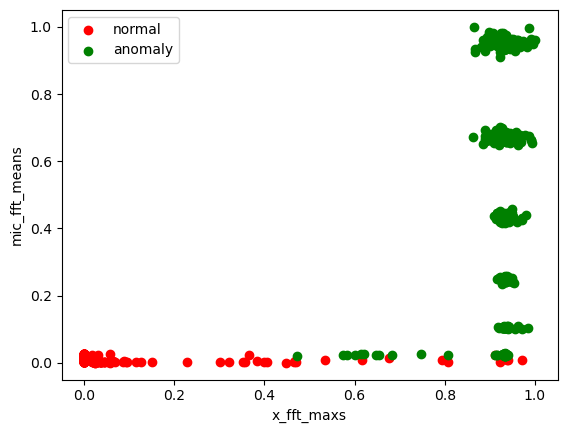

In [ ]:
# draw scatter plot with the features found
def features_plot(features, n_norm):
    plt.figure()

    x_norm = features[:n_norm, 0]
    y_norm = features[:n_norm, 1]
    x_anom = features[n_norm:, 0]
    y_anom = features[n_norm:, 1]


    plt.scatter(x_norm, y_norm, c='r', label='normal')
    plt.scatter(x_anom, y_anom, c='g', label='anomaly')

    plt.xlabel('x_fft_maxs')
    plt.ylabel('mic_fft_means')
    plt.legend()
    plt.show()

features = features_chosen
features_plot(features, n_norm = 300)

In [ ]:
""" while len(next_generation) < population_size:
    parent1, parent2 = random.choices(population, weights=fitness_values, k=2)
    child = []
    while len(child) < 3:
        gene = random.choice(parent1) if random.random() < 0.5 else random.choice(parent2)
        if gene not in child:
            child.append(gene)
    child = [1 if gene in child else 0 for gene in parent1]   # assume parent1 and parent2 have same genes
    if random.random() < mutation_rate:
        gene_to_mutate = random.randint(0, num_genes-1)
        child[gene_to_mutate] = 1 - child[gene_to_mutate]
    next_generation.append(child)
 """

' while len(next_generation) < population_size:\n    parent1, parent2 = random.choices(population, weights=fitness_values, k=2)\n    child = []\n    while len(child) < 3:\n        gene = random.choice(parent1) if random.random() < 0.5 else random.choice(parent2)\n        if gene not in child:\n            child.append(gene)\n    child = [1 if gene in child else 0 for gene in parent1]   # assume parent1 and parent2 have same genes\n    if random.random() < mutation_rate:\n        gene_to_mutate = random.randint(0, num_genes-1)\n        child[gene_to_mutate] = 1 - child[gene_to_mutate]\n    next_generation.append(child)\n '

In [ ]:
""" def genetic_algorithm(data, population_size, num_genes, calculate_fitness, mutation_rate, elitism_rate, num_generations):
    # initialize the population
    population = []
    for i in range(population_size):
        individual = [random.randint(0, 1) for j in range(num_genes)]   #######
        population.append(individual)
        # print(population)

    # run the evolution loop for num_generations
    for generation in range(num_generations):
        # evaluate the fitness of each individual in the population
        fitness_values = [calculate_fitness(individual, data) for individual in population]

        # select the fittest individuals for the next generation
        num_elites = int(elitism_rate * population_size)
        elites = sorted(range(len(population)), key=lambda i: fitness_values[i], reverse=True)[:num_elites]
        next_generation = [population[i] for i in elites]

        # breed new individuals to fill the rest of the next generation
        while len(next_generation) < population_size:
            parent1, parent2 = random.choices(population, weights=fitness_values, k=2)
            child = [parent1[i] if random.random() < 0.5 else parent2[i] for i in range(num_genes)]   #########
            if random.random() < mutation_rate:
                gene_to_mutate = random.randint(0, num_genes-1)
                child[gene_to_mutate] = 1 - child[gene_to_mutate]
            next_generation.append(child)

        # replace the old population with the new generation
        population = next_generation
        # print(population)

    # return the fittest individual found
    return max(population, key=lambda individual: calculate_fitness(individual, data)) """

' def genetic_algorithm(data, population_size, num_genes, calculate_fitness, mutation_rate, elitism_rate, num_generations):\n    # initialize the population\n    population = []\n    for i in range(population_size):\n        individual = [random.randint(0, 1) for j in range(num_genes)]   #######\n        population.append(individual)\n        # print(population)\n\n    # run the evolution loop for num_generations\n    for generation in range(num_generations):\n        # evaluate the fitness of each individual in the population\n        fitness_values = [calculate_fitness(individual, data) for individual in population]\n\n        # select the fittest individuals for the next generation\n        num_elites = int(elitism_rate * population_size)\n        elites = sorted(range(len(population)), key=lambda i: fitness_values[i], reverse=True)[:num_elites]\n        next_generation = [population[i] for i in elites]\n\n        # breed new individuals to fill the rest of the next generation\n    